# A Jupyter notebook where BTC data downloaded from Binance is prepped for traning

In [48]:
# Importing relevant libraries for data management and visualization
# ta library used for technichal analysis indicators

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
import pandas_ta as ta
import warnings
warnings.filterwarnings("ignore")

Data was downloaded from https://www.binance.com/en/landing/data
CSV files from sept2019 to nov2020 where used as it represents an acumulating phase according to the 4 year cycle theory.
I belive that from mid 2023 untill november 2024 there will be a similar accumulation phase for BTC so I decided to train the data with this time period.  Binance asks its users to download the historical data via its download links instead of the API so the servers dont get overwhelmed.

In [49]:
# specifying the path to csv files
path = "/home/martin/Downloads"
  
# list of csv files in the path
files = glob.glob(path + "/*.csv")
  
# defining an empty df to store content
btc_df = pd.DataFrame(columns=["date","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_volume",
                         "taker_buy_quote_volume","ignore"])
 
# reading all the csv files in the specified path and appending them to the btc_df
for filename in files:
    df = pd.read_csv(filename, names=["date","open","high","low","close","volume","close_time","quote_volume","count","taker_buy_volume",
                         "taker_buy_quote_volume","ignore"])
    btc_df = pd.concat([btc_df,df])  
btc_df.sort_values(by="date", inplace=True)
btc_df.head()

,date,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1567296000000,9588.74,9608.80,9579.34,9607.85,75.066945,1567296299999,719990.082021,891,42.693944,409497.287252,0
1,1567296300000,9604.57,9615.45,9594.00,9600.55,70.945642,1567296599999,681419.492632,561,18.906562,181685.336981,0
2,1567296600000,9598.48,9615.19,9598.02,9609.30,36.108642,1567296899999,346962.304284,578,21.347931,205124.153678,0
3,1567296900000,9609.31,9625.00,9609.30,9620.00,85.606839,1567297199999,823295.804760,951,42.620899,409907.741723,0
4,1567297200000,9620.00,9623.73,9608.14,9620.23,38.321111,1567297499999,368555.022540,575,15.023955,144511.599644,0


In [50]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131373 entries, 0 to 8627
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    131373 non-null  object 
 1   open                    131373 non-null  float64
 2   high                    131373 non-null  float64
 3   low                     131373 non-null  float64
 4   close                   131373 non-null  float64
 5   volume                  131373 non-null  float64
 6   close_time              131373 non-null  object 
 7   quote_volume            131373 non-null  float64
 8   count                   131373 non-null  object 
 9   taker_buy_volume        131373 non-null  float64
 10  taker_buy_quote_volume  131373 non-null  float64
 11  ignore                  131373 non-null  object 
dtypes: float64(8), object(4)
memory usage: 13.0+ MB


131,373 data points evrey 5m where gathered.  The date is represented in UNIX time withms unit.  Irrelevant data was dropped from the DF

In [51]:
btc_df["date"] = pd.to_datetime(btc_df["date"],unit='ms')
btc_df = btc_df.set_index('date')
btc_df.drop(["close_time","quote_volume","count","taker_buy_volume","taker_buy_quote_volume","ignore"], axis=1, inplace=True)
btc_df.sort_index(inplace=True)
btc_df.head()

btc_df.to_csv("bitcoin.csv")

To train the models pandas-ta was used to calculate returns and indicators

In [70]:
btc_df.ta.rsi(close='close', length=10, append=True)
rsi_conditions = [
    (btc_df['RSI_10'] > 80),
    (btc_df['RSI_10'] <= 80) & (btc_df['RSI_10'] > 25),
    (btc_df['RSI_10'] <= 25)  
]
rsi_signals=[-1,0,1]
btc_df["rsi_indicator"] = np.select(rsi_conditions,rsi_signals)

btc_df["log_return"] = ta.log_return(close=btc_df["close"])
btc_df.dropna(inplace=True)


This basic trading strategy uses the relative strenghth index (RSI) that describes if an asset is overbought or oversold.  With the RSI calculated over 10 periods (50min) we add a signal indicator to buy (1), hold (0) or sell (-1).  The limits between the signals are estimated.  Later we will optimize the limits fro better returns.


In [71]:
btc_df.head(10)

,open,high,low,close,volume,RSI_10,rsi_indicator,log_return,strategy,cstrategy,creturns,trades,strategy_net,cstrategy_net
date,,,,,,,,,,,,,,
2019-09-01 01:40:00,9631.60,9640.41,9629.27,9632.67,51.997107,63.841482,0,0.000325,0.00000,1.00000,1.001104,0.0,0.000000,1.000000
2019-09-01 01:45:00,9630.44,9637.97,9625.00,9625.80,59.317590,47.657728,0,-0.000713,-0.00000,1.00000,1.000390,0.0,-0.000000,1.000000
2019-09-01 01:50:00,9625.78,9629.05,9617.24,9617.24,51.697136,35.277079,0,-0.000890,-0.00000,1.00000,0.999500,0.0,-0.000000,1.000000
2019-09-01 01:55:00,9619.18,9621.00,9612.08,9614.99,80.086670,32.789317,0,-0.000234,-0.00000,1.00000,0.999266,0.0,-0.000000,1.000000
2019-09-01 02:00:00,9614.99,9616.00,9612.09,9615.52,114.672408,34.007360,0,0.000055,0.00000,1.00000,0.999321,0.0,0.000000,1.000000
2019-09-01 02:05:00,9614.40,9615.99,9610.00,9610.43,24.237566,28.496546,0,-0.000529,-0.00000,1.00000,0.998792,0.0,-0.000000,1.000000
2019-09-01 02:10:00,9609.64,9610.33,9601.06,9604.86,40.216940,23.805993,1,-0.000580,-0.00000,1.00000,0.998213,1.0,-0.000850,0.999150
2019-09-01 02:15:00,9604.86,9616.00,9603.02,9614.37,34.342723,41.936751,0,0.000990,0.00099,1.00099,0.999202,1.0,0.000139,0.999289
2019-09-01 02:20:00,9612.68,9614.27,9603.08,9606.12,53.330779,34.112546,0,-0.000858,-0.00000,1.00099,0.998344,0.0,-0.000000,0.999289


In [72]:
btc_df["rsi_indicator"].value_counts()

rsi_indicator
 0    127434
 1      2604
-1      1315
Name: count, dtype: int64

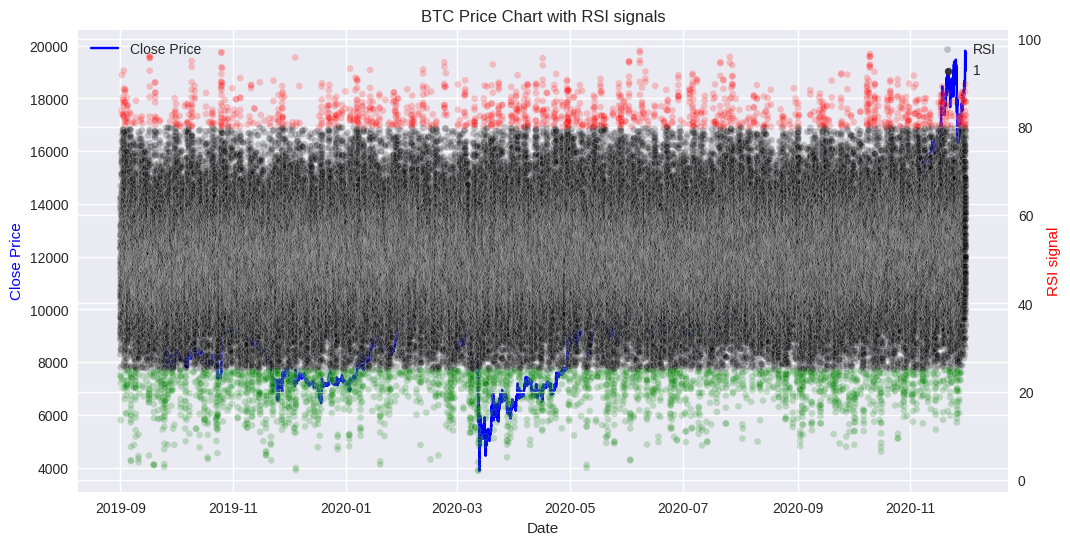

In [73]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a secondary y-axis for RSI
ax2 = ax1.twinx()

# Plot RSI on the secondary y-axis
colors = ['red' if s == -1 else 'green' if s == 1 else 'black' for s in btc_df['rsi_indicator']]
sns.scatterplot(data=btc_df, x='date', y='RSI_10', ax=ax2, label='RSI', color=colors, size=1 ,alpha=0.2)

# Plot close prices on the primary y-axis
sns.lineplot(data=btc_df, x='date', y='close', ax=ax1, label='Close Price', color='blue')


# Customize the chart
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('RSI signal', color='red')
ax1.set_title('BTC Price Chart with RSI signals')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [74]:
# Define the date range you want to plot
start_date = '2019-11-1'
end_date = '2019-11-5'

# Filter the DataFrame to include only the desired date range
filtered_df = btc_df[(btc_df.index >= start_date) & (btc_df.index <= end_date)]

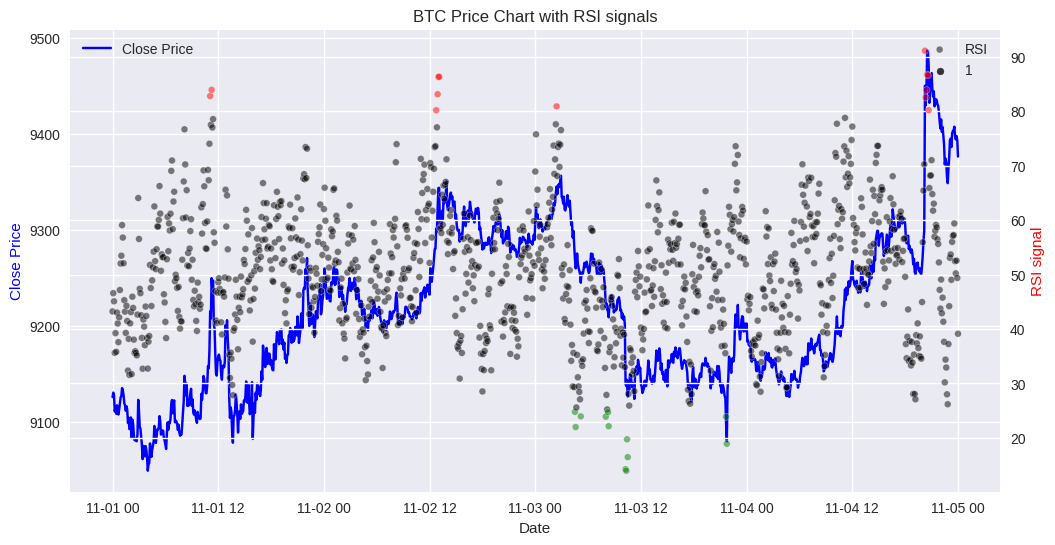

In [75]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a secondary y-axis for RSI
ax2 = ax1.twinx()

# Plot RSI on the secondary y-axis
colors = ['red' if s == -1 else 'green' if s == 1 else 'black' for s in filtered_df['rsi_indicator']]
sns.scatterplot(data=filtered_df, x='date', y='RSI_10', ax=ax2, label='RSI', color=colors, size=1 ,alpha=0.5)

# Plot close prices on the primary y-axis
sns.lineplot(data=filtered_df, x='date', y='close', ax=ax1, label='Close Price', color='blue')


# Customize the chart
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('RSI signal', color='red')
ax1.set_title('BTC Price Chart with RSI signals')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

The green dots show buy positions and the red dots sell positions.  The graph shows that the RSI strategy can somewhat recognize local bottoms to buy and local tops to sell.

# Backtesting

In [76]:
btc_df['strategy'] = btc_df['rsi_indicator'].shift(1) * btc_df['log_return']
btc_df.tail()

,open,high,low,close,volume,RSI_10,rsi_indicator,log_return,strategy,cstrategy,creturns,trades,strategy_net,cstrategy_net
date,,,,,,,,,,,,,,
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,-1,0.001648,0.000000,2.515026,2.044694,1.0,-0.000850,0.013858
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,-1,0.000900,-0.000900,2.512763,2.046536,0.0,-0.000900,0.013845
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,-1,0.002765,-0.002765,2.505823,2.052203,0.0,-0.002765,0.013807
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,0,-0.005333,0.005333,2.519223,2.041287,1.0,0.004483,0.013869
2020-11-30 23:55:00,19641.37,19700.00,19635.00,19695.87,473.001131,67.387319,0,0.002771,0.000000,2.519223,2.046952,0.0,0.000000,0.013869


In [77]:
btc_df[["log_return", "strategy"]].sum().apply(np.exp)
btc_df["cstrategy"] = btc_df["strategy"].cumsum().apply(np.exp) 
btc_df["creturns"] = btc_df['log_return'].cumsum().apply(np.exp)
btc_df.tail()

,open,high,low,close,volume,RSI_10,rsi_indicator,log_return,strategy,cstrategy,creturns,trades,strategy_net,cstrategy_net
date,,,,,,,,,,,,,,
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,-1,0.001648,0.000000,1.814791,2.043104,1.0,-0.000850,0.013858
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,-1,0.000900,-0.000900,1.813158,2.044944,0.0,-0.000900,0.013845
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,-1,0.002765,-0.002765,1.808151,2.050607,0.0,-0.002765,0.013807
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,0,-0.005333,0.005333,1.817820,2.039700,1.0,0.004483,0.013869
2020-11-30 23:55:00,19641.37,19700.00,19635.00,19695.87,473.001131,67.387319,0,0.002771,0.000000,1.817820,2.045359,0.0,0.000000,0.013869


btc_df[["creturns", "cstrategy"]].plot(figsize = (12 , 8), fontsize = 12)
plt.show()

In [78]:
tp_year = 12 * 24 * 365.25 # 5min trading periods per year

In [79]:
ann_mean = btc_df[["log_return", "strategy"]].mean() * tp_year
ann_std = btc_df[["log_return", "strategy"]].std() * np.sqrt(tp_year)
sharpe = (np.exp(ann_mean) - 1) / ann_std
sharpe

log_return    1.043966
strategy      1.907516
dtype: float64

# Trading Costs

In [80]:
btc_df['rsi_indicator'].value_counts()

rsi_indicator
 0    127434
 1      2604
-1      1315
Name: count, dtype: int64

In [81]:
btc_df["trades"] = btc_df['rsi_indicator'].diff().fillna(0).abs() # absolute change in position

In [82]:
btc_df.trades.value_counts()

trades
0.0    127857
1.0      3496
Name: count, dtype: int64

over 6000 single trades.  each trade has costs that must be included.

In [83]:
commissions = 0.00075 # reduced Binance commission 0.075%
other = 0.0001 # proportional costs for bid-ask spread & slippage

# total proportional trading costs (negative log return)
ptc = np.log(1 - commissions) + np.log(1 - other)
ptc

-0.0008502863910375247

In [84]:
btc_df["strategy_net"] = btc_df['strategy'] + btc_df['trades'] * ptc # strategy returns net of costs
btc_df["cstrategy_net"] = btc_df.strategy_net.cumsum().apply(np.exp)

In [85]:
btc_df.tail()

,open,high,low,close,volume,RSI_10,rsi_indicator,log_return,strategy,cstrategy,creturns,trades,strategy_net,cstrategy_net
date,,,,,,,,,,,,,,
2020-11-30 23:35:00,19641.58,19679.67,19594.46,19674.15,431.120626,81.510968,-1,0.001648,0.000000,1.814791,2.043104,1.0,-0.000850,0.092942
2020-11-30 23:40:00,19674.15,19695.46,19629.24,19691.87,360.297399,82.668892,-1,0.000900,-0.000900,1.813158,2.044944,0.0,-0.000900,0.092858
2020-11-30 23:45:00,19691.87,19747.05,19670.00,19746.40,586.810308,85.725596,-1,0.002765,-0.002765,1.808151,2.050607,0.0,-0.002765,0.092602
2020-11-30 23:50:00,19746.41,19747.03,19625.05,19641.37,472.335209,62.234879,0,-0.005333,0.005333,1.817820,2.039700,1.0,0.004483,0.093018
2020-11-30 23:55:00,19641.37,19700.00,19635.00,19695.87,473.001131,67.387319,0,0.002771,0.000000,1.817820,2.045359,0.0,0.000000,0.093018


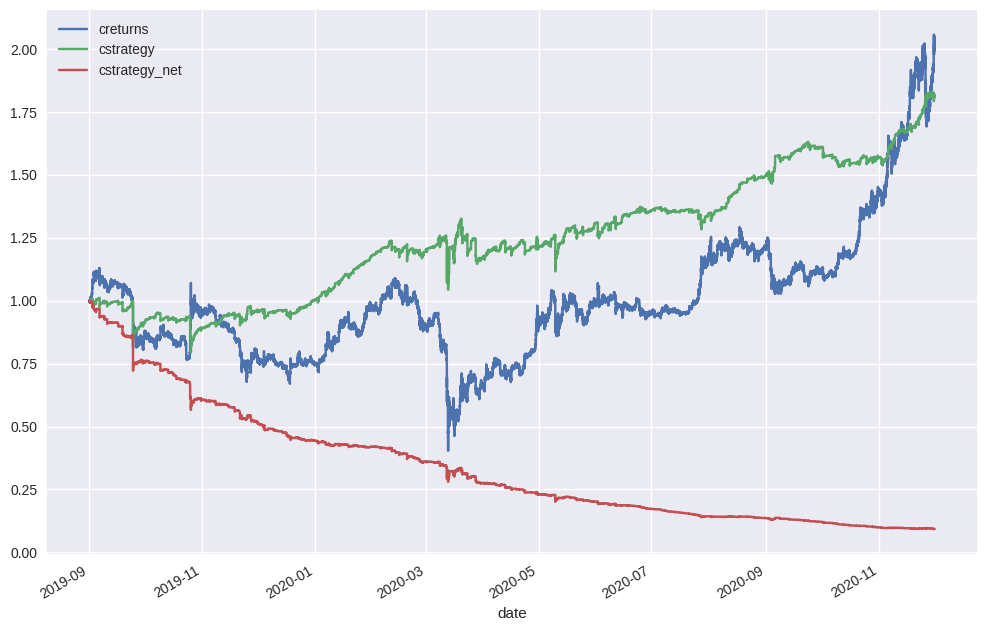

In [86]:
btc_df[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

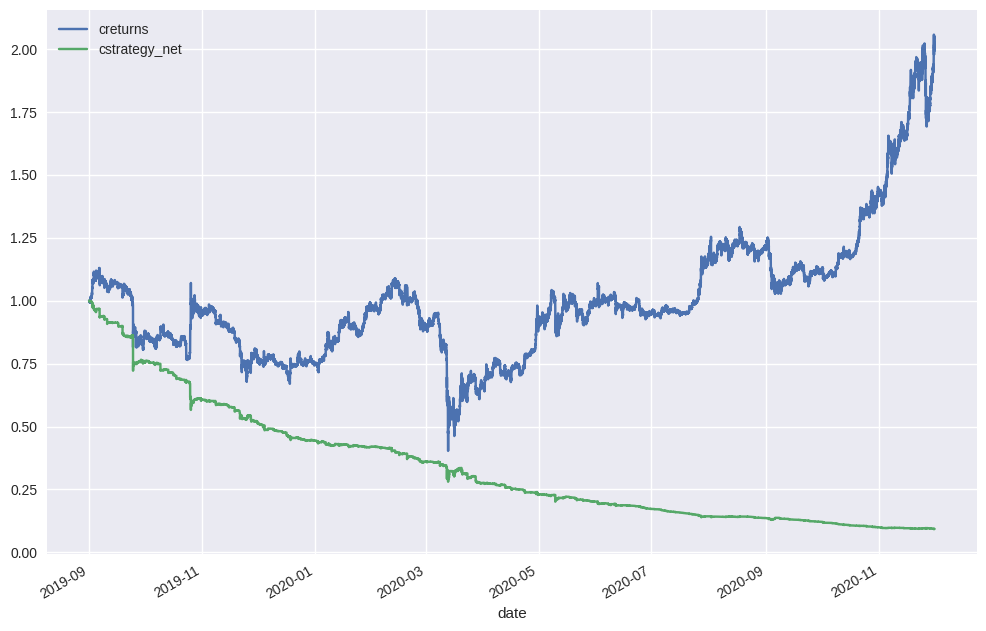

In [87]:
btc_df[["creturns", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()